# Topic: Fama-French Equity Factors over Business Cycles

* Feburary 20 Python Markdown Submission: Data read-in, visualization, and EDA
* Group members: Kenneth Chen, Yoshiyasu Kawamura, Byungsoo Kim, Patrick Wang
* For the data and detailed python code please visit our GitHub repo: https://github.com/patrickwjwang/equity-cycle


## Import packages and set directories

In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Risk factors data

In [2]:
# Read processed data files
ff6_weekly_df = pd.read_csv(os.path.join(data_dir, 'ff6_weekly.csv'))
ff6_monthly_df = pd.read_csv(os.path.join(data_dir, 'ff6_monthly.csv'))
hxz_weekly_df = pd.read_csv(os.path.join(data_dir, 'hxz_weekly.csv'))
hxz_monthly_df = pd.read_csv(os.path.join(data_dir, 'hxz_monthly.csv'))

In [3]:
# Create summmary stat for weekly ff6
ff6_weekly_summary = ff6_weekly_df.describe()
start, end = min(ff6_weekly_df['Date']), max(ff6_weekly_df['Date'])  # start and end date
print(f"Fama-French 5 factors and momentum start date: {start}; end date {end}")
# ff6_weekly_summary

Fama-French 5 factors and momentum start date: 1964-01-03; end date 2023-12-29


In [4]:
# Create summmary stat for weekly HXZ
hxz_weekly_summary = hxz_weekly_df.describe()
start, end = min(hxz_weekly_df['Date']), max(hxz_weekly_df['Date'])  # start and end date
print(f"HXZ factors start date: {start}; end date {end}")
# hxz_weekly_summary

HXZ factors start date: 1967-01-06; end date 2022-12-30


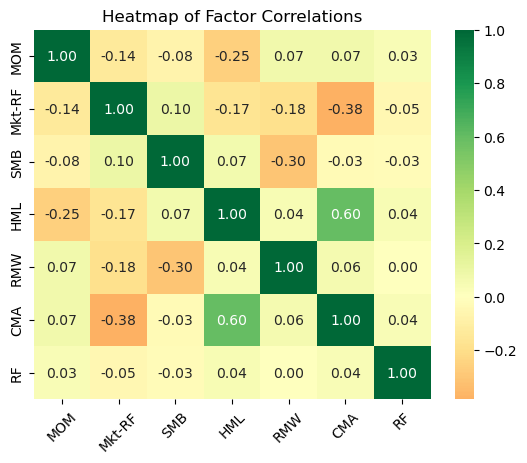

In [5]:
corr_matrix = ff6_weekly_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.xticks(rotation=45)
plt.title('Heatmap of Factor Correlations')
# plt.savefig(os.path.join(graph_dir, 'ff6_weekly_heatmap.png'))
plt.show()

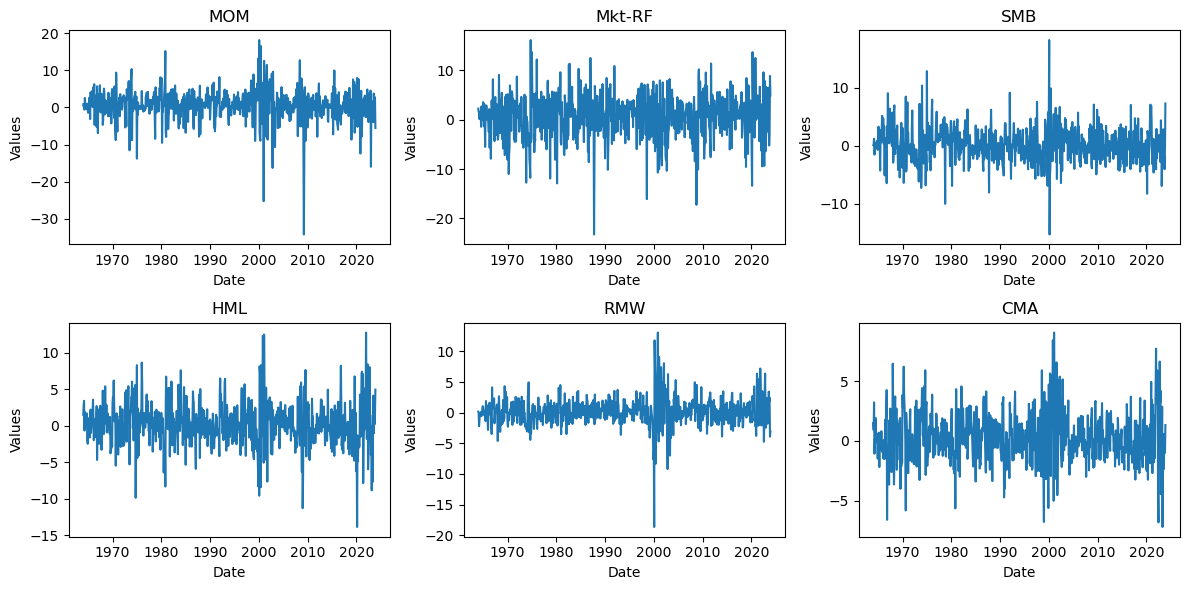

In [6]:
# Line chart for ff6 monthly
ff6_monthly_df['Year_Month'] = pd.to_datetime(ff6_monthly_df['Year_Month'])
variables = ['MOM', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']  # excluding 'RF'

# Create a 2x3 subplo6
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    axs[i].plot(ff6_monthly_df['Year_Month'], ff6_monthly_df[var])
    axs[i].set_title(var)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Values')
plt.tight_layout()
plt.show()

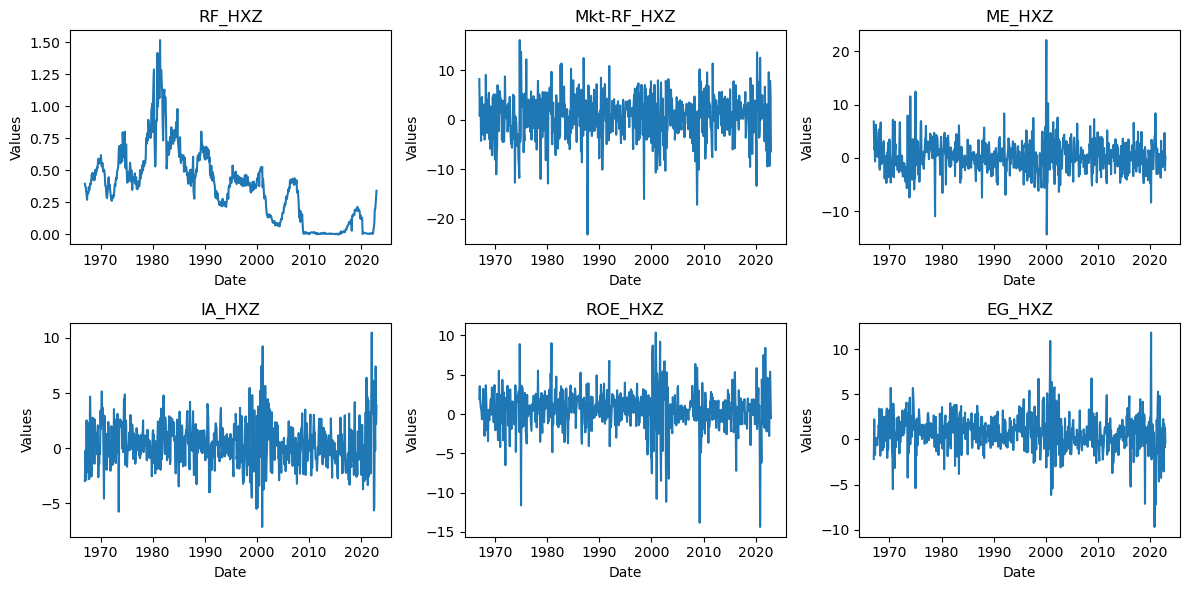

In [7]:
# Line chart for hxz monthly
hxz_monthly_df['Year_Month'] = pd.to_datetime(hxz_monthly_df['Year_Month'])
variables = ['RF_HXZ', 'Mkt-RF_HXZ', 'ME_HXZ', 'IA_HXZ', 'ROE_HXZ', 'EG_HXZ']

# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    axs[i].plot(hxz_monthly_df['Year_Month'], hxz_monthly_df[var])
    axs[i].set_title(var)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Values')
plt.tight_layout()
plt.show()

## 2. Business Cycles

(To do) Explain how we divide business cycles

In [8]:
# Read the data
bsc_file = os.path.join(raw_data_dir, 'business_cycles.csv')
bsc_df = pd.read_csv(bsc_file)
bsc_df['Date'] = pd.to_datetime(bsc_df['Date'])

Plot the conference board index and mark the recession period in grey

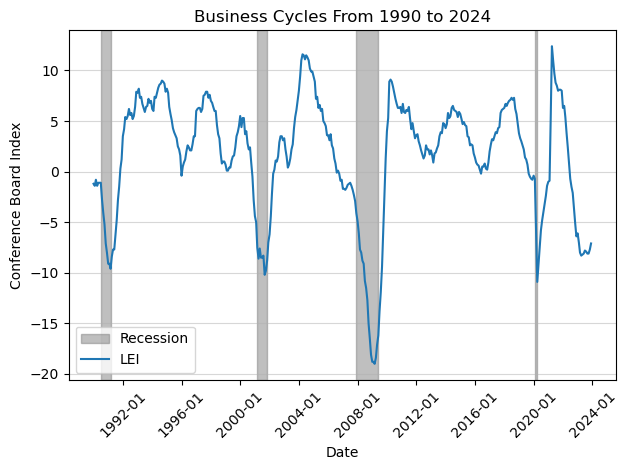

In [9]:
# Find the start and end dates of recession periods
recession_periods = []
in_recession = False
for i, row in bsc_df.iterrows():
    if row['Recession'] == 1 and not in_recession:        
        start_date = row['Date']  # Start of a new recession
        in_recession = True
    elif row['Recession'] == 0 and in_recession:        
        end_date = bsc_df.iloc[i-1]['Date']  # End of current recession
        recession_periods.append((start_date, end_date))
        in_recession = False

# Plot the Cof_idx
fig, ax = plt.subplots()
ax.plot(bsc_df['Date'], bsc_df['Cof_idx'], label='LEI')

# Shade the recession periods using the list of tuples
for start_date, end_date in recession_periods:
    ax.axvspan(start_date, end_date + pd.Timedelta(days=1), color='grey', alpha=0.5)

# Set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.grid(True, alpha=0.5)

# Add legend for recession
recession_patch = Patch(color='grey', alpha=0.5, label='Recession')
plt.legend(handles=[recession_patch, *ax.get_legend_handles_labels()[0]])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Conference Board Index')
plt.title('Business Cycles From 1990 to 2024')
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'business_cycles.png'))
plt.show()

## 3. Stock data

Using the business cycles data outlined in Section 2, we define the commencement of a new business cycle as the end of a recession. From 1990 to 2024, four recessions have concluded, resulting in three complete cycles and one incomplete cycle.

We have gathered stock data from the S&P 500, S&P MidCap 400, and S&P SmallCap 600. These collectively form what is known as the S&P 1500, covering the period from October 10th, 1990, to February 14th, 2024, sourced from the Bloomberg terminal. As of February 2024, the S&P 1500 comprises 1506 different U.S. stocks. At the start of each cycle, we assess how many stocks from the current S&P 1500 have complete and available data.

This stock data will be utilized to construct optimal portfolios and to select relevant features for our analysis.


In [10]:
# Read the stock data into dataframes
price_1_file = os.path.join(data_dir, 'price_1.csv')
price_2_file = os.path.join(data_dir, 'price_2.csv')
price_3_file = os.path.join(data_dir, 'price_3.csv')
price_4_file = os.path.join(data_dir, 'price_4.csv')
df_1 = pd.read_csv(price_1_file, index_col='Date')
df_2 = pd.read_csv(price_2_file, index_col='Date')
df_3 = pd.read_csv(price_3_file, index_col='Date')
df_4 = pd.read_csv(price_4_file, index_col='Date')

# Iterate through each df and print start and end dates and number of stocks
dfs = [df_1, df_2, df_3, df_4]
for i, df in enumerate(dfs):
    start, end = df.index.min(), df.index.max()
    num_columns = df.shape[1]  # Number of columns
    print(f"Cycle {i+1} starts from {start}, ends with {end}, and has {num_columns} stocks.")

Cycle 1 starts from 1990-10-10, ends with 2001-09-21, and has 284 stocks.
Cycle 2 starts from 2001-09-20, ends with 2009-03-09, and has 663 stocks.
Cycle 3 starts from 2009-03-09, ends with 2020-03-23, and has 843 stocks.
Cycle 4 starts from 2020-03-23, ends with 2024-02-14, and has 1191 stocks.


### 3.1 EDA on stock data

In [11]:
# Some EDA and graphs on stock data

## 4. Construct optimal potfolios using stock data

The `OptimalPortfolios` class, located in the `src` directory under `optimal_portfolios.py`, processes daily stock price data to calculate the mean and covariance of stocks. It then constructs portfolios on the efficient frontier. Portfolios on the efficient frontier represent the optimal balance of risk (variance) and expected return.

When initializing `OptimalPortfolios`, the user must specify the number of portfolios (`num_pfo`). The expected returns for these portfolios will be evenly distributed between the 50th and 90th quantiles of stock returns. The user also have the option to specify `corr_threshold`, which will remove the stocks with correlation above this threshold.

For example, consider a user inputs a dataframe containing daily prices of 200 stocks from 2011 to 2014. If the 50th quantile of stock returns in this period is 12%, and the 90th quantile is 25%, setting `num_pfo` to 5 would result in five portfolios. These portfolios have expected returns evenly spaced between 12% and 25%, and each is positioned on the efficient frontier. Users can retrieve the daily, weekly, monthly, and annual returns of these portfolios using the methods `daily_return`, `weekly_return`, `monthly_return`, and `annual_return`, respectively. Additionally, users can call `pfo_returns` and `pfo_vars` to view the returns and variances of these portfolios over the entire timeframe (4 years in this example) covered by the dataframe.


In [12]:
# print(inspect.getsource(OptimalPortfolios))

### 4.1 Construct portfolios on sample data

To verify the accuracy of our code, we initially test it on a smaller sample dataset. This dataset comprises stocks from the S&P 500, S&P MidCap 400, and S&P SmallCap 600, collectively referred to as the S&P 1500, spanning from March 1996 to November 2001. As of February 2024, the S&P 1500 includes 1506 different US stocks. Among these, 760 stocks were available during our sample period.

Our objective is to plot the efficient frontier to evaluate the performance of our class. Ideally, the plot should show an increase in expected portfolio variance with an increase in expected return. 

It's important to note that this plot represents only a segment of the entire efficient frontier. The primary purpose of this project is not to create the efficient frontier itself but to investigate the relationship between various factors and optimal portfolios across different business cycles. Therefore, this part of the code is designed to generate optimal portfolios that exemplify diverse investor profiles for subsequent analysis.


Number of observations = 1448; available stocks = 760
0 stocks removed, 760 stocks remain.


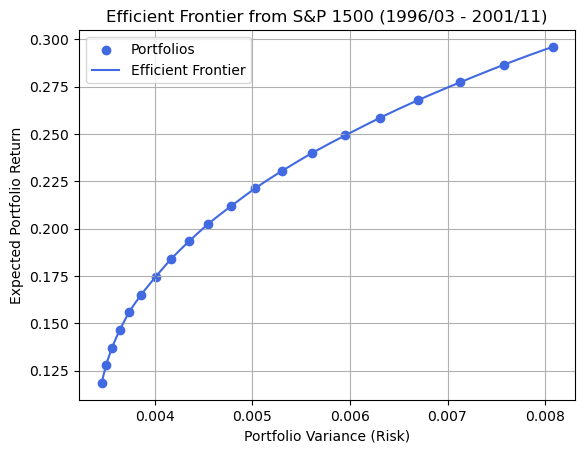

In [13]:
# Example usage of OptimalPortfolios using sample data
sample_stock_file = os.path.join(data_dir, 'price_sample_960301_011130.csv')
df = pd.read_csv(sample_stock_file, index_col='Date')  # remember to set Date as index
print(f"Number of observations = {df.shape[0]}; available stocks = {df.shape[1]}")

# Initialize the class and calculate efficient frontier
num_pfo = 20
ef_pfo = OptimalPortfolios(df, num_pfo, corr_threshold=0.99)
ef_pfo.calculate_efficient_frontier()

# Convert lists to numpy arrays for easier manipulation
pfo_returns_array = np.array(ef_pfo.pfo_returns)
pfo_vars_array = np.array(ef_pfo.pfo_vars)
sorted_indices = np.argsort(pfo_vars_array)
pfo_vars_sorted = pfo_vars_array[sorted_indices]
pfo_returns_sorted = pfo_returns_array[sorted_indices]

# Get individual stock returns and variances
individual_returns = ef_pfo._mu
individual_vars = np.diag(ef_pfo._cov_matrix)

# Creating the spline to smooth efficent frontier
spline = make_interp_spline(pfo_vars_sorted, pfo_returns_sorted, k=3)  # k is the degree of the spline
smooth_vars = np.linspace(pfo_vars_sorted.min(), pfo_vars_sorted.max(), 300)
smooth_returns = spline(smooth_vars)

# Plotting the efficient frontier using the sample data
plt.scatter(ef_pfo.pfo_vars, ef_pfo.pfo_returns, color='royalblue', label='Portfolios')
plt.plot(smooth_vars, smooth_returns, color='royalblue', label='Efficient Frontier')
plt.title('Efficient Frontier from S&P 1500 (1996/03 - 2001/11)')
plt.xlabel('Portfolio Variance (Risk)')
plt.ylabel('Expected Portfolio Return')
plt.grid(True)
plt.legend()
plt.show()


### 4.2 Construct optimal portfolios across cycles

Since cycle 4 has the highest number of stocks, the inverse of the covariance matrix become more sensitive to high correlation stocks. Therefore, we have to set the correlation threshold lower to create optimized portfolio. 

In [14]:
# Initialize OptimalPortfolios class
num_pfo = 3
corr_threshold = 0.99
ef1 = OptimalPortfolios(df_1, num_pfo, corr_threshold)
ef2 = OptimalPortfolios(df_2, num_pfo, corr_threshold)
ef3 = OptimalPortfolios(df_3, num_pfo, corr_threshold)
ef4 = OptimalPortfolios(df_4, num_pfo, corr_threshold**5)  # lower the threshold for optimization

# Calculate efficient frontier
ef_instances = [ef1, ef2, ef3, ef4]
for ef in ef_instances:    
    ef.calculate_efficient_frontier()

5 stocks removed, 279 stocks remain.
0 stocks removed, 663 stocks remain.
56 stocks removed, 787 stocks remain.
324 stocks removed, 867 stocks remain.


Combine the optimal portfolios from different cycles into a single dataset. Add a new column named 'Cycle' to indicate the specific cycle each portfolio belongs to. Then, save the daily, weekly, monthly, and yearly returns of these combined optimal portfolios into separate CSV files.

In [19]:
ef_combined_daily = ef1.daily_return.head(0).copy()
ef_combined_weekly = ef1.weekly_return.head(0).copy()
ef_combined_monthly = ef1.monthly_return.head(0).copy()
ef_combined_annual = ef1.annual_return.head(0).copy()

for idx, ef in enumerate(ef_instances):
    ef_daily = ef.daily_return.copy()
    ef_weekly = ef.weekly_return.copy()
    ef_monthly = ef.monthly_return.copy()
    ef_annual = ef.annual_return.copy()    
    ef_daily['Cycle'] = idx + 1
    ef_weekly['Cycle'] = idx + 1
    ef_monthly['Cycle'] = idx + 1
    ef_annual['Cycle'] = idx + 1
    
    ef_combined_daily = pd.concat([ef_combined_daily, ef_daily])
    ef_combined_weekly = pd.concat([ef_combined_weekly, ef_weekly])
    ef_combined_monthly = pd.concat([ef_combined_monthly, ef_monthly])
    ef_combined_annual = pd.concat([ef_combined_annual, ef_annual])

# daily_path = os.path.join(data_dir, 'optimal_pfo_return_daily.csv')
# weekly_path = os.path.join(data_dir, 'optimal_pfo_return_weekly.csv')
# monthly_path = os.path.join(data_dir, 'optimal_pfo_return_monthly.csv')
# yearly_path = os.path.join(data_dir, 'optimal_pfo_return_yearly.csv')
# ef_combined_daily.to_csv(daily_path)
# ef_combined_weekly.to_csv(weekly_path)
# ef_combined_monthly.to_csv(monthly_path)
# ef_combined_annual.to_csv(yearly_path)


From the line chart below, we can observe that the portfolios within each cycle follow the same monthly return trend. This outcome aligns with our objective of capturing the preferences of different types of investors. Additionally, it's noticeable that Portfolio 3, characterized by high risk and high return, typically experiences the greatest variability in monthly returns. This observation is in line with our expectations and further corroborates our findings from the efficient frontier analysis.


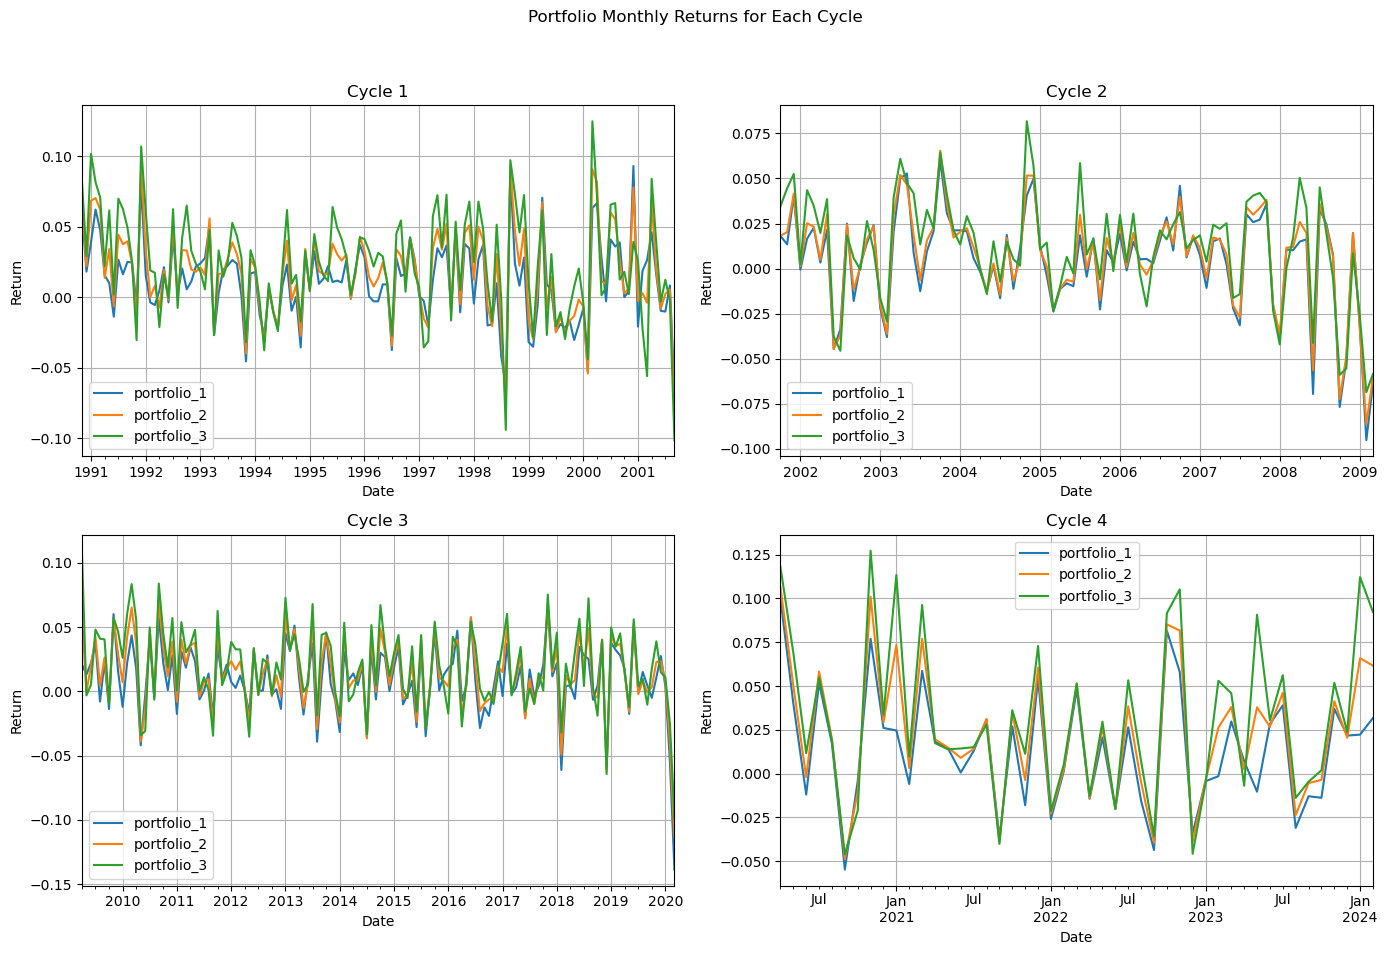

In [47]:
# Creating subplots for each cycle
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Portfolio Monthly Returns for Each Cycle')
cycles = ef_combined_monthly['Cycle'].unique()
for i, cycle in enumerate(cycles):
    ax = axes[i//2, i%2]
    cycle_data = ef_combined_monthly[ef_combined_monthly['Cycle'] == cycle]
    
    cycle_data[['portfolio_1', 'portfolio_2', 'portfolio_3']].plot(ax=ax)
    ax.set_title(f'Cycle {int(cycle)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
# plt.savefig(os.path.join(graph_dir, 'optimal_monthly_returns_cycles.png'))
plt.show()

We can create graphs to observe the number of stocks utilized in each portfolio. It is evident that most portfolios comprise approximately 30 to 70 stocks. This observation suggests that removing some highly correlated stocks might not significantly impact our analysis, as less than a quarter of the stocks are typically employed in these portfolios.

{'Cycle 1': [62, 54, 31], 'Cycle 2': [31, 33, 29], 'Cycle 3': [39, 45, 35], 'Cycle 4': [43, 41, 34]}


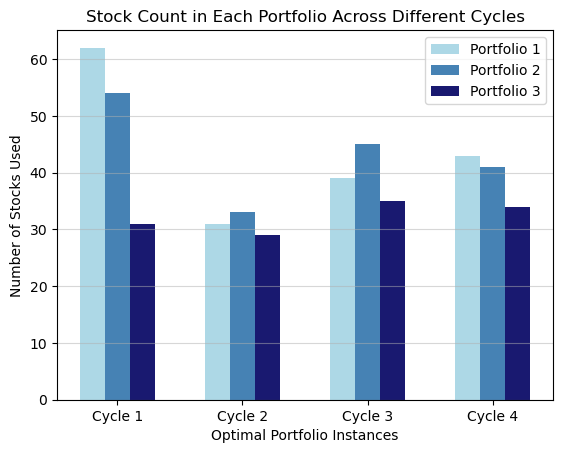

In [48]:
# Calculate number of stocks used for each portfolio
ticker_counts = {}
threshold = 1e-10
ef_names = ['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4']

# Loop through each instance and each portfolio
for ef_name, ef in zip(ef_names, ef_instances):    
    counts = []
    for i in range(1, num_pfo + 1):
        count = len(ef.weight_df[ef.weight_df[f'weight_{i}'] > threshold])
        counts.append(count)
    ticker_counts[ef_name] = counts
print(ticker_counts)

# Create a bar chart
fig, ax = plt.subplots()
positions = range(len(ef_names))
width = 0.2
colors = ['lightblue', 'steelblue', 'midnightblue']
for i in range(num_pfo):
    pos = [p + width*i for p in positions]
    counts = [ticker_counts[ef_name][i] for ef_name in ef_names]
    ax.bar(pos, counts, width, label=f'Portfolio {i+1}', color=colors[i % len(colors)])

# Adding labels and title
ax.set_xlabel('Optimal Portfolio Instances')
ax.set_ylabel('Number of Stocks Used')
ax.set_title('Stock Count in Each Portfolio Across Different Cycles')
ax.set_xticks([p + width for p in range(len(ef_names))])
ax.set_xticklabels(ef_names)
ax.legend()
ax.yaxis.grid(True, alpha=0.5)
# plt.savefig(os.path.join(graph_dir, 'stock_count_optimal_cycles.png'))
plt.show()


### 4.3 Construct portfolios for each sub-cycles

After sub-cycles are divided within each cycle, we will repeat the process to construct portfolios for each sub-cycle. Specifically, if we divide Cycle 1 into 'contraction', 'trough', 'expansion', and 'recession', we will construct three portfolios representing high, medium, and low expected return investors. Therefore, for each business cycle, we will have $3 \times 4 = 12$ portfolios. Since we have four major cycles, we will have approximately 48 portfolios in total.


## 5. Feature Engineering and Selection

### 5.1 Create our own risk factors

In addition to the 8 factors (see section 1) we've obtained from various data libraries, such as the Fama-French five factors, Carhart's momentum factor, and the HXZ investment (I/A) and profitability (ROE) factors, we also develop our own risk factors, like liquidity.

For instance, to create the liquidity factor, we first form $K$ portfolios (consider $K$ to be 3, for example), where the top portfolio contains stocks with the highest liquidity and the bottom portfolio contains stocks with the lowest liquidity. Stocks within each portfolio are equally weighted. The liquidity factor is then determined by calculating the return difference between the top and bottom portfolios.

Another approach involves considering two risk factors: liquidity and credit risk. We create $K \times K$ (e.g., $3 \times 3$) portfolios for this purpose. Firstly, stocks are grouped based on liquidity, with the top group having the highest liquidity and the bottom group the lowest. Within each liquidity group, stocks are further sorted by credit risk, forming 3 subgroups. The liquidity factor is calculated as the average return of the 3 high-liquidity portfolios minus the average return of the 3 low-liquidity portfolios. Similarly, the credit risk factor is derived by calculating the average return difference between the three high credit risk portfolios and the three low credit risk portfolios.

In [21]:
# Read the liquidity data into dataframes
liquidity_1_file = os.path.join(data_dir, 'turnover_1.csv')
liquidity_2_file = os.path.join(data_dir, 'turnover_2.csv')
liquidity_3_file = os.path.join(data_dir, 'turnover_3.csv')
liquidity_4_file = os.path.join(data_dir, 'turnover_4.csv')
liq_df_1 = pd.read_csv(liquidity_1_file, index_col='Date')
liq_df_2 = pd.read_csv(liquidity_2_file, index_col='Date')
liq_df_3 = pd.read_csv(liquidity_3_file, index_col='Date')
liq_df_4 = pd.read_csv(liquidity_4_file, index_col='Date')

# Iterate through each df and print start and end dates and number of stocks
liq_dfs = [liq_df_1, liq_df_2, liq_df_3, liq_df_4]
for i, df in enumerate(liq_dfs):
    start, end = df.index.min(), df.index.max()
    num_columns = df.shape[1]  # Number of columns
    print(f"Cycle {i+1} starts from {start}, ends with {end}, and has {num_columns} stocks liquidity.")


Cycle 1 starts from 1990-10-10, ends with 2001-09-21, and has 201 stocks liquidity.
Cycle 2 starts from 2001-09-20, ends with 2009-03-09, and has 644 stocks liquidity.
Cycle 3 starts from 2009-03-06, ends with 2020-03-23, and has 834 stocks liquidity.
Cycle 4 starts from 2020-03-20, ends with 2024-02-14, and has 1174 stocks liquidity.


### 5.2 Feature selection